# <span style="color:#00c5cd; font-size:34px;" >Airline predictor</span>
### <span style="color:#ff4444;">Þórhildur Þorleiksdóttir and Lea El Hage </span>
#### <span style="color:#ffb14c;">Artificial Intelligence And Applied Methods, 2017</span>

In [174]:
import pandas as pd
import matplotlib.pyplot as plt


In [184]:
data = pd.read_csv('flights.csv', encoding='ISO-8859-1', usecols=[0,1,2,4,7,11,24], low_memory=False) #,25,26,27,28,29,30])
# Year0 | Month1 | Day2 | Airline4 | Origin_airport7 | Departure_delay11 | Cancelled24 | Cancellation_reason25 | Air_system_delay26 | Security_delay27 | Airline_delay28 | Late_Aircraft_delay29 | 
#Weather_delay30

In [186]:
flight_data = data.rename(columns={'YEAR':'year','MONTH':'month','DAY':'day',
                                   'AIRLINE':'airline','ORIGIN_AIRPORT':'airport','DEPARTURE_DELAY':'delay', 
                                   'CANCELLED':'cancelled'})


flight_data['date'] = pd.to_datetime(flight_data[['year','month','day']]).dt.date

flight_data['delay'] = (flight_data['delay'] > 0).astype(int)

In [187]:
#Total flight per month

flight_data['count'] = 0
flights_per_month = flight_data.groupby(['month'])['count'].count().to_frame()

In [188]:
#Delayed flights per month

flight_data_delays = flight_data[(flight_data.delay == 1)]
delayed_flights_per_month = flight_data_delays.groupby(['month'])['count'].count().to_frame()
delayed_flights_per_month = delayed_flights_per_month.rename(columns={'count':'d_count'})

In [189]:
#Cancelation of flights per month

flight_data_cancelation = flight_data[(flight_data.cancelled == 1)]
cancelled_flights_per_month = flight_data_cancelation.groupby(['month'])['count'].count().to_frame()
cancelled_flights_per_month = cancelled_flights_per_month.rename(columns={'count':'c_count'})


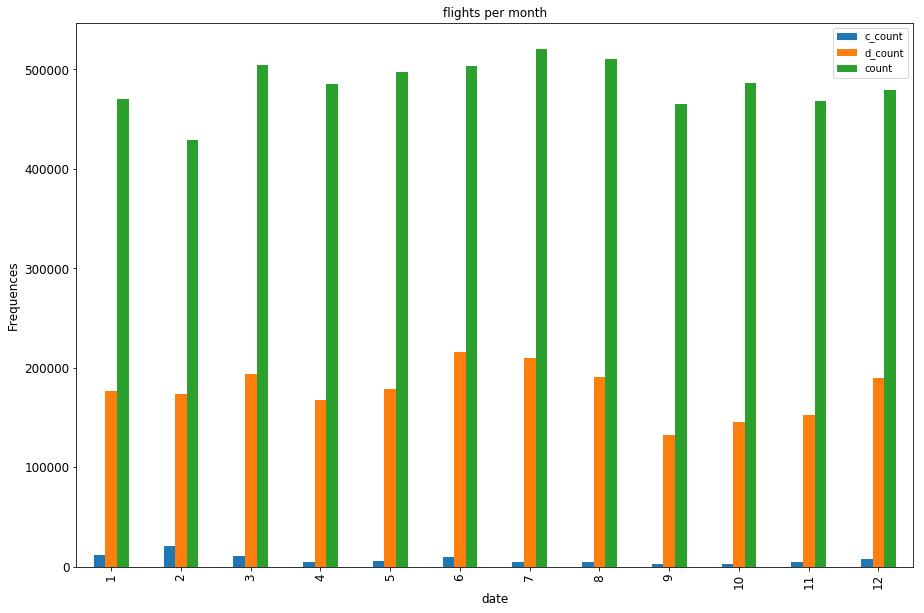

In [190]:
#Mergin the dataframes on date for the plot

merged_frame = pd.concat([flights_per_month, delayed_flights_per_month, cancelled_flights_per_month], axis=1)

ax = merged_frame[['c_count','d_count','count']].plot(kind='bar', title='flights per month', figsize=(15,10),fontsize=12)
ax.set_xlabel('date', fontsize=12)
ax.set_ylabel('Frequences', fontsize=12)
plt.show()



In [ ]:
flights_per_day